# Feature Selection



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.features.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5, 1.0, 'X v y')

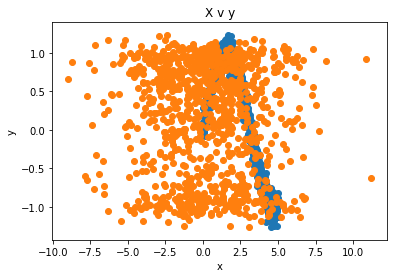

In [30]:
x = np.linspace(0, 5, 1000)
X = np.random.normal(0, 3, size = 1000 * 2).reshape(-1, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=1000) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [3]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=10, store_in_sample_predictions=False, n_jobs=1)
model.fit(X, y)

  0%|          | 0/200 [00:00<?, ?it/s]Starting burn
Starting sampling
  0%|          | 0/200 [00:00<?, ?it/s]Starting burn
Starting sampling
  0%|          | 0/200 [00:00<?, ?it/s]Starting burn
Starting sampling
100%|██████████| 200/200 [00:00<00:00, 264.59it/s]


SklearnModel(alpha=0.95, beta=2.0, initializer=None, n_burn=50, n_chains=4,
             n_jobs=1, n_samples=200, n_trees=10, sigma_a=0.001, sigma_b=0.001,
             store_acceptance_trace=False, store_in_sample_predictions=False,
             thin=0.1,
             tree_sampler=<bartpy.samplers.unconstrainedtree.treemutation.UnconstrainedTreeMutationSampler object at 0x7f86d8cf5710>)

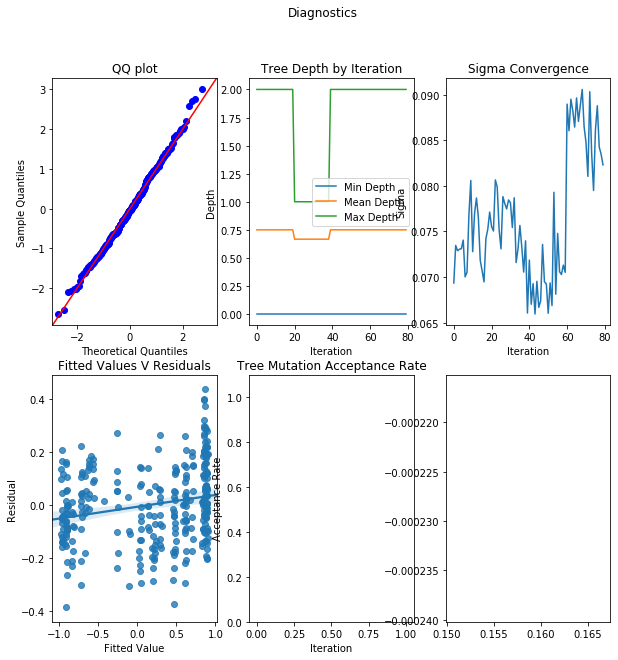

In [5]:
from matplotlib import pyplot as plt

from bartpy.diagnostics.residuals import plot_qq, plot_homoskedasity_diagnostics
from bartpy.diagnostics.sampling import plot_tree_mutation_acceptance_rate
from bartpy.diagnostics.sigma import plot_sigma_convergence
from bartpy.diagnostics.trees import plot_tree_depth
from bartpy.sklearnmodel import SklearnModel


def plot_diagnostics(model: SklearnModel):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 10))
    fig.suptitle("Diagnostics")
    plot_qq(model, ax1)
    plot_tree_depth(model, ax2)
    plot_sigma_convergence(model, ax3)
    plot_homoskedasity_diagnostics(model, ax4)
    plot_tree_mutation_acceptance_rate(model, ax5)
    plt.show()

plot_diagnostics(model)

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [7]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

In [8]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.3870967741935484, 1: 0.2903225806451613}
Is Kept [ True False]


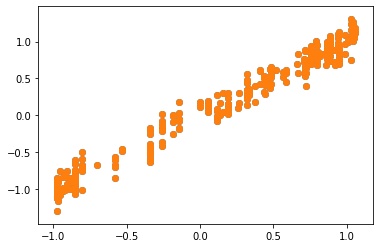

In [12]:
plt.scatter(pipeline.predict(X), y)

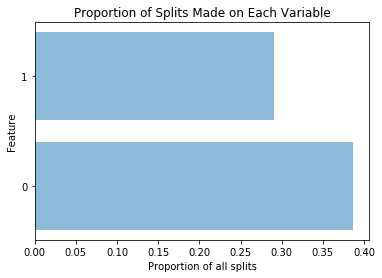

In [10]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [41]:
model = SklearnModel(n_samples=200, n_burn=200, n_trees=5, store_in_sample_predictions=False, n_jobs=-1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.75, "local"), model)
pipeline_model = pipeline.fit(X, y)

[0, 1]


In [42]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

Thresholds {0: 0.2355833333333333, 1: 0.20002080123266563}
Feature Proportions {0: 0.36666666666666664, 1: 0.3}
[0, 1]
Is Kept [ True  True]


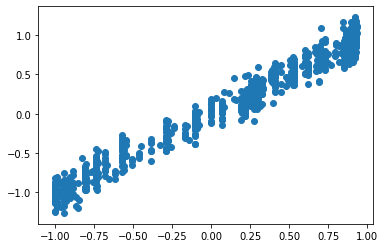

In [43]:
plt.scatter(model.predict(X), y)

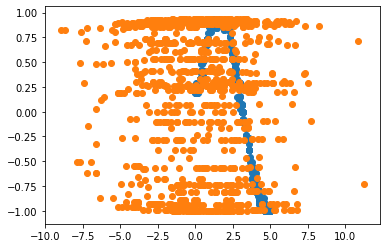

In [44]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

[0, 1]


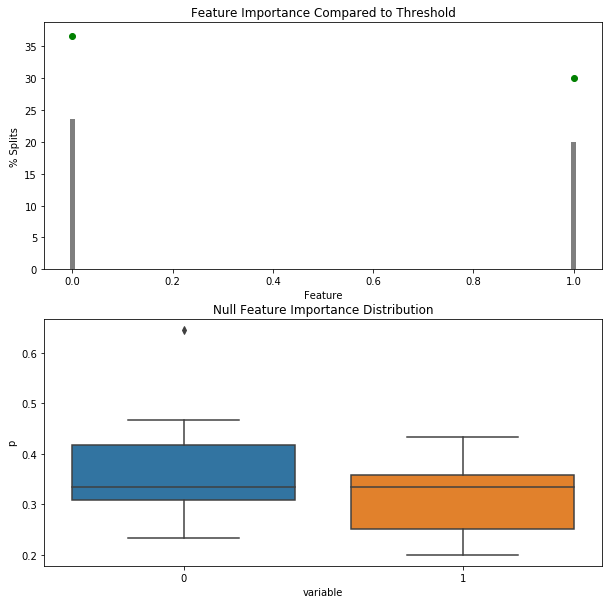

In [45]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

# Feature Selection

The approach so far is useful - but it doesn't give a complete picture of the importance of a single variable.  There are at least two big limitations:
1. % of splits doesn't give up an idea of how much a variable is improving accuracy
2. In cases of high correlation, the model might be able to as easily split on different variables

To get a more direct account of a single variable, we can instead permute that variable, and see how the out of sample RMSE changes.  The bigger the increase in RMSE that scrambling a variable, the more important the variable is.

 sampling
100%|██████████| 500/500 [00:03<00:00, 149.82it/s]


([1.9940201197552054, 1.7725380792387906],
 [12.008000152552047,
  9.09288827203163,
  9.054099758328693,
  9.283864462256066,
  9.142283513760258,
  9.222353797135137,
  9.00239934938098,
  9.148670658157634,
  9.055046636293039,
  8.970603322643589,
  9.458484446352864,
  9.296695022571134,
  9.23656900931175,
  9.268895620066376,
  9.32391110039848,
  9.256408016399494,
  9.315903439736617,
  9.208512952538053,
  9.253782032299535,
  9.229344196566029])

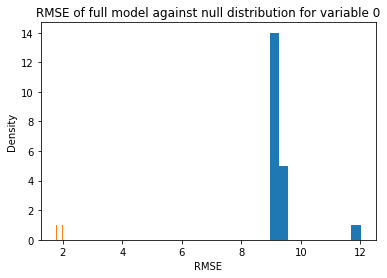

In [21]:
from bartpy.features.featureimportance import feature_importance
feature_importance(model, X, y, 0)

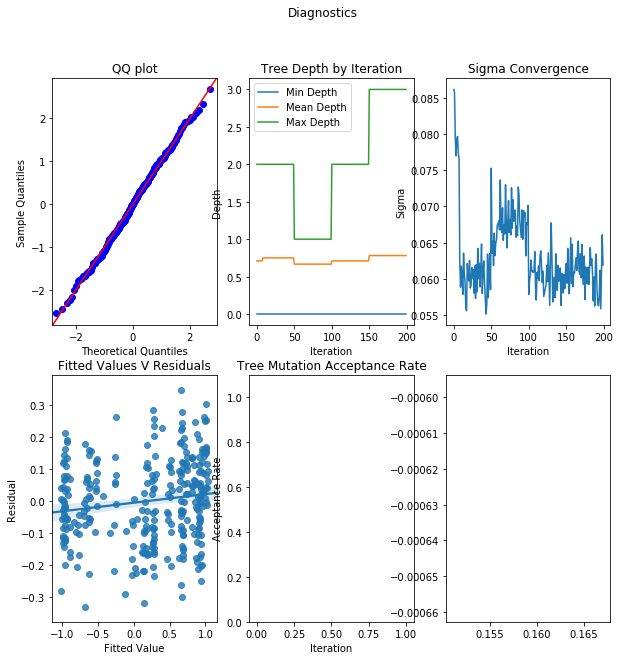

In [19]:
from bartpy.diagnostics.diagnostics import plot_diagnostics
plot_diagnostics(model)